In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_lg
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

ValueError: mount failed

In [ ]:
import os
import re
import spacy
import math
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
#------------------------------------------------------------------------------------------------
#files_paths
#files_path[0] quries (questions to test the model )  name: cran.all.1400
#files_path[1] label - cran.qry sorguId document Id name: cran.qry
#files_paths[2]) name :cranqrel instructiions
#files_path[3] are the articals summeries
#------------------------------------------------------------------------------------------------

In [ ]:
def read_file(file_path):
  with open(file_path,"r",encoding="utf-8") as file:
    file = file.read()
    #print(file)
    return file

def get_files_names(folder_path):
    files = []
    for file in os.listdir(folder_path):
      path = os.path.join(folder_path, file)
      files.append(path)
    return files
#print(read_file(files_paths[0]))

In [ ]:
def list_collection_files(folder_path):
  docs=[]
  files_paths = get_files_names(folder_path)
  for file_path in files_paths:
    print(f"path : {file_path} file loading ...................")
    #doc = read_file(file_path)[:1000]
    doc = read_file(file_path)
    docs.append(doc)
    #print(doc)
  return docs
ctr=0
folder_path = "/content/drive/MyDrive/datas/cran"
files_txts_list = list_collection_files(folder_path)



In [ ]:
def load_docs(pattern,file_path):
  txt = read_file(file_path)
  print(files_paths[0])
  matches = re.findall(pattern, txt, re.DOTALL)
  return matches

Ar_qu_pairs = np.empty((0,3),dtype=object)
article_dic={}
query_dic={}
patterns= [r'I (\d{3})([\s\S]*?)(?=\.I \d{3}|$)',r"(\d) (\d{1,}) (-\d|\d)","",r'\.I (\d+)\n(.+?)(?=(?:\n\.I \d+)|\Z)']
files_paths = get_files_names(folder_path)
for idx in range(len(files_paths)):
  if idx!=2:
    matches =  load_docs(patterns[idx],files_paths[idx])
    if idx ==0:
      #files_path[0] quries (questions to test the model )  name: cran.all.1400
      for matching in matches :
         query_dic[int(matching[0])]=matching[1][4:-1]
    elif idx==1:
       for matching in matches:
        #files_path[1] label - cran.qry sorguId document Id name: cran.qry
        Ar_qu_pairs = np.append(Ar_qu_pairs, [[matching[0], matching[1], matching[2]]], axis=0)
    elif idx ==3 :
      #print("articales  matches size ", len(matches ))
      #files_path[3] are the articals summeries
      for matching in matches:

        article_dic[int(matching[0])]=matching[1]

print(len(article_dic))
print(len(query_dic))
print(Ar_qu_pairs.shape)


In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    porter_stemmer = PorterStemmer()
    tokens = [porter_stemmer.stem(word) for word in tokens]
    return tokens

In [ ]:
def build_inverted_index(docs):
    inverted_index = {}
    for doc_id, text in docs.items():
        tokens = preprocess_text(text)
        word = {}
        for token in tokens:
            if token not in word:
                word[token] = 0
            word[token] += 1

        for token, count in word.items():
            if token not in inverted_index:
                inverted_index[token] = {'docId_and_freq': [], '_term_freq_over_docs': 0}
            inverted_index[token]['docId_and_freq'].append([doc_id, count])
            inverted_index[token]['_term_freq_over_docs'] += count
    return inverted_index


testing

In [ ]:
def get_posting_list(inverted_index, query):
  posting_lists = []
  for term in query:
      if term in inverted_index:
          posting_lists.append(inverted_index[term]['docId_and_freq'])
  return posting_lists


In [ ]:
def merge_algorithm(pos1 ,pos2):
  p1,p2= 0,0
  answer = []
  while ((p1 is not None) and ( p2 is not None)):
    if p1 < len(pos1) and p2 < len(pos2):
      docsID1,freq1=pos1[p1]
      docsID2,freq2 =pos2[p2]
      if docsID1==docsID2 :
        answer.append([docsID1,max(freq1,freq2)])
        p1+=1
        p2+=1
      elif docsID1<docsID2:
        p1+=1
      else:
        p2+=1
    elif (p1>=len(pos1) ) or (p2>=len(pos2)):
      p1= None
      p2 = None
  return answer

In [ ]:
  vectors= build_inverted_index(article_dic)

In [ ]:
def bool_retriving(inverted_index,query):
  query_after_processsing= preprocess_text(query)
  posting_lists = get_posting_list(inverted_index, query_after_processsing)
  if not posting_lists:
      return []
  result = posting_lists[0]
  for posting in posting_lists[1:]:
      result = merge_algorithm(result, posting)
  return result

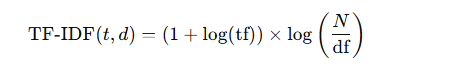

In [ ]:
def tf_clc(inverted_index):
    tf = {}
    for word, docIds_freq in inverted_index.items():
        for docId, freq in docIds_freq['docId_and_freq']:
            if docId not in tf:
                tf[docId] = {}
            tf[docId][word] = freq
    return tf


In [ ]:
def df_clc(inverted_index, word):
    df = len(inverted_index[word]['docId_and_freq'])
    return df


In [ ]:
def idf_clc(docs , inverted_index):
  N=0
  idf={}
  total_tokens_length = [len(preprocess_text(doc)) for _, doc in article_dic.items()]
  for doc_len in total_tokens_length:
    N+=doc_len
  for word, docs_freqs in inverted_index.items():
    df = df_clc(inverted_index, word)
    if df:
      idf[word] = math.log(N / df)
    else:
       idf[word]  = 0
  return idf

In [ ]:
def tfidf_clc(tf, idf):
    tf_idf = {}
    for docId, words in tf.items():
        tf_idf[docId] = {}
        for word, tf_value in words.items():
            tf_idf[docId][word] = tf_value * idf.get(word, 0)
    return tf_idf

In [ ]:

def test_tfidf(inverted_index,article_dic,query):
  query_tf = {}
  query_tf_idf = {}
  #---------------tf-idf--------------------------------------------
  tf = tf_clc(inverted_index)
  idf = idf_clc(article_dic, inverted_index)
  tfidf = tfidf_clc(tf, idf)

  #----------------------process query --------------------------
  qi = preprocess_text(query)
  for tkn in qi:
      if tkn not in query_tf:
          query_tf[tkn] = 0
      query_tf[tkn] += 1

  for word, freq_over_q in query_tf.items():
      query_tf_idf[word] = freq_over_q * idf.get(word, 0)
  return query_tf_idf


query= input("enter ur qeury :")
test_tfidf(vectors,article_dic,query)


In [ ]:
def cosin_similarity(vec1, vec2):
  common_words = []
  multi_vecs = 0
  for key in vec1.keys():
      if key in vec2.keys():
          common_words.append(key)
  for common_word in common_words:
      multi_vecs += vec2[common_word] * vec1[common_word]
  v1_intensity = math.sqrt(sum([x**2 for x in vec2.values()]))
  v2_intensity = math.sqrt(sum([x**2 for x in vec1.values()]))
  multi_intensities = v1_intensity * v2_intensity
  if multi_intensities != 0:
      cos_theta = multi_vecs / multi_intensities
  else:
      cos_theta = 0.0
  return cos_theta

In [ ]:
def computation(inverted_index, article_dic, query):
    query_tf = {}
    query_tf_idf = {}
    cos_similarities = {}

    #---------------tf-idf--------------------------------------------
    tf = tf_clc(inverted_index)
    idf = idf_clc(article_dic, inverted_index)
    tfidf = tfidf_clc(tf, idf)

    #----------------------process query --------------------------
    qi = preprocess_text(query)
    for tkn in qi:
        if tkn not in query_tf:
            query_tf[tkn] = 0
        query_tf[tkn] += 1

    for word, freq_over_q in query_tf.items():
        query_tf_idf[word] = freq_over_q * idf.get(word, 0)

    for id, tf_idf in tfidf.items():
        cos_similarities[id] = cosin_similarity(query_tf_idf, tf_idf)
    return cos_similarities

In [ ]:
ans= []
query= input("enter ur qeury :")

res= bool_retriving(vectors,query)
res.sort(key=lambda x: x[1]) # Sort the res list in place
print(res) # Print the sorted res list

In [ ]:

query= input("enter ur qeury :")
answer_list=[]
ans_dict = computation(vectors,article_dic,query)
for docId, relevance in ans_dict.items():
  if relevance>0.4:
    answer_list.append(docId)
print(answer_list)
